## The best vision models for fine-tuning


When selecting an architecture for our task, we need to consider the characteristics of our dataset. Our dataset is significantly different from the Imagenet dataset, on which most pre-trained models are trained. Therefore, we need to look at models that have performed well on similar datasets.

In the [notebook](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning) by Jeremy Howard and [Thomas Capelle](https://tcapelle.github.io/about/) of [Weights and Biases](https://wandb.ai/), they evaluated several models on two different datasets: [Oxford IIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/) and [Kaggle Planet](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data). The Kaggle Planet dataset contains satellite images of Earth, which are not present in Imagenet.

Since our dataset is also different from Imagenet, we need to choose a model that has performed well on datasets with similar characteristics to ours. The <code>vit_small_patch32</code> model stands out as a good fit for our dataset for several reasons. Firstly, it is memory-efficient, which is important when working with large datasets. Secondly, it is one of the fastest models among the top 15, which means it can process a large number of images quickly. Lastly, it has performed well on the Kaggle Planet dataset, which is similar to our dataset in terms of its characteristics.

Also, <code>convnext_tiny</code> is currently the most accurate option amongst architectures that don't have a fixed resolution. It makes it a useful model to experiment with progressive resizing.

Let's compare both the models.

## Set up

In [1]:
from fastai.vision.all import *

set_seed(42)
trn_path = '/kaggle/input/ideitify'
files = get_image_files(trn_path)

## Metric

It can be challenging to achieve high accuracy on all classes, and even small errors in prediction can have significant consequences. Therefore, top-3 and top-5 accuracies will be apt metrics for our dataset considering the high amount of visual similarity between some of the classes. 

In [2]:
top_3 = partial(top_k_accuracy, k=3)
top_5 = partial(top_k_accuracy, k=5)
metrics = [error_rate, accuracy, top_3, top_5]

In [3]:
dls = ImageDataLoaders.from_folder(
    trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(256, method=ResizeMethod.Squish), 
    batch_tfms=aug_transforms(size=224, min_scale=0.75), 
)

## ViT - Vision image Transformer

In [ ]:
learn = vision_learner(dls, arch="vit_small_patch32_224", metrics=metrics, path='.').to_fp16()

## About fastai's fine_tune() method

In [4]:
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    *,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      /opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py
Type:      method


The <code>fine_tune()</code> method in the fastai library is a high-level interface for fine-tuning pre-trained deep learning models on new datasets. This method has two phases:

1) Trains the randomly added head for one epoch, with all other layers frozen. 
2) Unfreeze all the layers, and trains them for the number of epochs.

The first phase allows the random weights of the head to adapt to the dataset. In the second phase, each layer is trained using <code>discriminative learning rates</code>. The early layers are trained with a lower learning rate and the later layers are trained with a higher learning. This lets later layers fine-tune quickly than earlier layers.

## About lr_find() method

The <code>lr_find()</code> method in the fastai library is a technique used to find the optimal learning rate for training deep learning models. This method involves starting with an extremely small learning rate and training the model on one mini-batch. After the first mini-batch, the learning rate is increased by a percentage, and the model is trained again on another mini-batch. This process is repeated, with the learning rate increasing by a certain percentage each time, until the loss starts to increase.

By plotting the learning rates against the corresponding losses, we can determine the optimal learning rate by identifying the <code>steepest downward slope</code> of the curve. The learning rate corresponding to this point is chosen as the optimal learning rate for training the model.

For more info, read this [paper](https://arxiv.org/abs/1506.01186) by Leslie Smith.

SuggestedLRs(valley=0.002511886414140463, slide=0.00363078061491251)

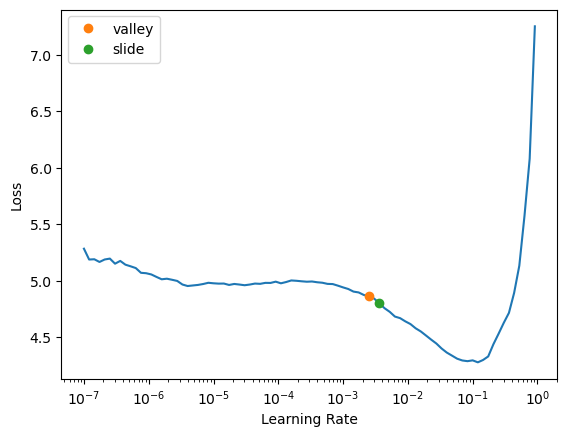

In [5]:
learn.lr_find(suggest_funcs=(valley, slide))

In [6]:
learn.fine_tune(4, 0.02)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,top_k_accuracy,time
0,2.894571,2.161515,0.549841,0.450159,0.676825,0.783492,03:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.872867,1.312344,0.380952,0.619048,0.813968,0.882540,02:53
1,1.512738,1.150227,0.342857,0.657143,0.852063,0.909841,02:54
2,1.025702,0.943339,0.280000,0.720000,0.879365,0.926984,02:54
3,0.745273,0.889904,0.257143,0.742857,0.888889,0.935238,02:52


## convNext

In [7]:
learn = vision_learner(dls, arch="convnext_tiny", metrics=metrics, path='.').to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


SuggestedLRs(valley=0.0008317637839354575, slide=6.30957365501672e-05)

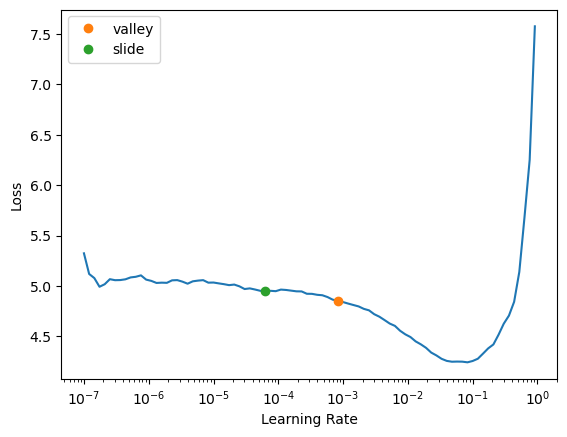

In [8]:
learn.lr_find(suggest_funcs=(valley, slide))

In [9]:
learn.fine_tune(4, 0.005)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,top_k_accuracy,time
0,3.009560,2.087929,0.559365,0.440635,0.645714,0.757460,02:52


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.849623,1.535445,0.440635,0.559365,0.766984,0.852698,02:59
1,1.482573,1.246377,0.361905,0.638095,0.831111,0.897778,03:01
2,1.098757,1.082702,0.318095,0.681905,0.855238,0.915556,03:01
3,0.851252,1.061461,0.309841,0.690159,0.859048,0.913651,02:59


We will stick to <code>vit_small_patch32</code> as it performs slightly better than the connext model. We can combine them both incase we are building an ensemble model.